### Deep Belief Networks, DBN
深度信念網路 又名 Sigmoid信念網路

In [1]:
from sklearn.neural_network import BernoulliRBM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt

In [2]:
class DBN():
    def __init__(self):
        self.rbm_weights = []
        self.rbm_biases = []
        self.rbm_h_act = []
        
        self.model = None
        self.history = None
        
    def load_train_data(self, train_data, train_labels):
        self.train_data = train_data
        self.train_labels = train_labels
        
    def load_test_data(self, test_data, test_labels):
        self.test_data = test_data
        self.test_labels = test_labels
        
    def set_parameters(self, epochs, batch_size, hidden_size, rbm_iters, rbm_learning_rate):        
        self.epochs = epochs
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.rbm_iters = rbm_iters
        self.rbm_learning_rate = rbm_learning_rate
        
    def pretrain(self):
        visual_layer = self.train_data
        for i in range(len(self.hidden_size)):
            print("[DBN] Layer {} Pre-Training".format(i+1))
            rbm = BernoulliRBM(n_components=self.hidden_size[i],
                               n_iter=self.rbm_iters[i],
                               learning_rate=self.rbm_learning_rate[i],
                               verbose=True,
                               batch_size=128)
            rbm.fit(visual_layer)
            self.rbm_weights.append(rbm.components_)
            self.rbm_biases.append(rbm.intercept_hidden_)
            self.rbm_h_act.append(rbm.transform(visual_layer))
            visual_layer = self.rbm_h_act[-1]
            
    def build_model(self):
        model = Sequential()
        for i in range(len(self.hidden_size)):
            if i==0:
                model.add(Dense(self.hidden_size[i], activation="relu", name="rbm_{}".format(i),
                                input_dim=self.train_data.shape[1]))
            else:
                model.add(Dense(self.hidden_size[i], activation="relu", name="rbm_{}".format(i)))
        model.add(Dense(self.train_labels.shape[1], activation="softmax"))
        
        model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
        
        self.model = model
    
    def set_WB(self):
        for i in range(len(self.hidden_size)):
            layer = self.model.get_layer("rbm_{}".format(i))
            layer.set_weights([self.rbm_weights[i].trainspose(), self.rbm_biases[i]])
            
    def train_model(self):
        self.history = self.model.fit(train_data, train_labels, 
                                      epochs=self.epochs, 
                                      batch_size=self.batch_size, 
                                      validation_split=0.2)  
        print(self.history.history.keys())
        
    def model_evaluate(self, test_data, test_labels):
        loss, acc = self.model.evaluate(test_data, test_labels, verbose=0)        
        return loss, acc  
    
    def visual_train_status(self):
        loss = self.history.history["loss"]
        val_loss = self.history.history["val_loss"]
        acc = self.history.history["accuracy"]
        val_acc = self.history.history["val_accuracy"]
        epochs = range(1, len(loss)+1)

        plt.figure(figsize=(12,3))
        plt.subplot(121)
        plt.plot(epochs, loss, "bo-", label="Training Loss")
        plt.plot(epochs, val_loss, "ro--", label="Validation Loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epochs')
        plt.legend()    
        plt.subplot(122)
        plt.plot(epochs, acc, "bo-", label="Training Acc")
        plt.plot(epochs, val_acc, "ro--", label="Validation Acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epochs')
        plt.legend()
        plt.show()
    
def preprocess_mnist_data(train_data, train_labels, test_data, test_labels):
    train_data = train_data.reshape(train_data.shape[0],784)
    test_data = test_data.reshape(test_data.shape[0],784)
    train_data = train_data.astype("float32")
    test_data = test_data.astype("float32")
    train_data /= 255
    test_data /= 255
    
    train_labels = to_categorical(train_labels)
    test_labels = to_categorical(test_labels)
    return train_data, train_labels, test_data, test_labels



In [3]:
epochs = 3
batch_size = 128
hidden_size = [6]
rbm_iters = [4]
rbm_learning_rate = [0.01]

(train_data, train_labels), (test_data, test_labels) = mnist.load_data()# 分割訓練集資料與測試集資料
train_data, train_labels, test_data, test_labels = preprocess_mnist_data(train_data, train_labels, test_data, test_labels)



In [4]:
dbn = DBN()
dbn.load_train_data(train_data, train_labels)
dbn.set_parameters(epochs=epochs,
                   batch_size=batch_size,
                   hidden_size=hidden_size,
                   rbm_iters=rbm_iters,
                   rbm_learning_rate=rbm_learning_rate)
dbn.pretrain()
dbn.build_model()
dbn.train_model()

[DBN] Layer 1 Pre-Training
[BernoulliRBM] Iteration 1, pseudo-likelihood = -256.30, time = 1.18s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -222.59, time = 1.66s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -203.39, time = 1.53s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -201.39, time = 1.60s
Train on 48000 samples, validate on 12000 samples
Epoch 1/3
48000/48000 [==============================] - 1s 27us/sample - loss: 1.2334 - accuracy: 0.6275 - val_loss: 0.6392 - val_accuracy: 0.8240
Epoch 2/3
48000/48000 [==============================] - 1s 14us/sample - loss: 0.5740 - accuracy: 0.8364 - val_loss: 0.4750 - val_accuracy: 0.8627
Epoch 3/3
48000/48000 [==============================] - 1s 13us/sample - loss: 0.4714 - accuracy: 0.8632 - val_loss: 0.4188 - val_accuracy: 0.8800
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [5]:
loss ,acc = dbn.model_evaluate(test_data, test_labels)
print('Test loss:', loss)
print('Test accuracy:', acc)

Test loss: 0.4278378657579422
Test accuracy: 0.8752


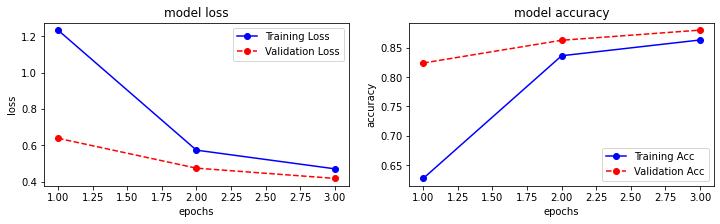

In [6]:
dbn.visual_train_status()